**1. Imports and synthetic data generation**

In [ ]:
!pip3 install torch torchvision torchaudio pytorch-lightning

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Create a dataset for time series forecasting.
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Input: a window of length `seq_length`
        x = self.data[idx:idx+self.seq_length]
        # Target: the next value in the series
        y = self.data[idx+self.seq_length]
        # Return tensors with shape [seq_length, 1] and [1]
        return torch.FloatTensor(x).unsqueeze(-1), torch.FloatTensor([y])

# Generate synthetic data: a sine wave with noise.
np.random.seed(42)
t = np.linspace(0, 100, 1000)
data = np.sin(t) + 0.1 * np.random.randn(1000)

# Hyperparameters for dataset
seq_length = 20
dataset = TimeSeriesDataset(data, seq_length)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

**2. LSTM**

In [ ]:
import pytorch_lightning as pl
import torch.nn as nn

class LSTMForecast(pl.LightningModule):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        # x: [batch, seq_length, input_size]
        out, _ = self.lstm(x)
        # Use the output from the last time step
        out = out[:, -1, :]
        return self.fc(out)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        self.log("train_loss", loss, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Train the LSTM model.
model_lstm = LSTMForecast()
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=10)
trainer.fit(model_lstm, train_loader, val_loader)

**3. Transformer**

In [ ]:
import math
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn

# Positional encoding to inject sequence order information.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [batch, seq_length, d_model]
        return x + self.pe[:, :x.size(1)]

class TransformerForecast(pl.LightningModule):
    def __init__(self, input_size=1, d_model=32, nhead=4, num_layers=2, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        # x: [batch, seq_length, input_size]
        x = self.input_proj(x)               # [batch, seq_length, d_model]
        x = self.pos_encoder(x)              # add positional info
        x = x.transpose(0, 1)                # [seq_length, batch, d_model] for Transformer
        x = self.transformer_encoder(x)      # [seq_length, batch, d_model]
        x = x[-1, :, :]                     # use the last time step's output
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        self.log("train_loss", loss, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Train the Transformer model.
model_transformer = TransformerForecast()
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=10)
trainer.fit(model_transformer, train_loader, val_loader)

**4. TCN**

In [ ]:
import torch.nn as nn
import pytorch_lightning as pl


# A single TCN block with a residual connection.
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=(kernel_size - 1) * dilation,
                              dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        # A 1x1 convolution to match dimensions for the residual connection.
        self.conv1x1 = nn.Conv1d(out_channels, out_channels, 1)
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.conv1x1.weight)

    def forward(self, x):
        out = self.conv(x)
        # Crop the output to maintain causality.
        out = out[:, :, :x.size(2)]
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1x1(out)
        return out + x  # Residual connection

class TCNForecast(pl.LightningModule):
    def __init__(self, input_size=1, num_channels=[16, 16, 16], kernel_size=3, lr=1e-3):
        super().__init__()
        self.lr = lr
        layers = []
        in_channels = input_size
        for i, out_channels in enumerate(num_channels):
            dilation = 2 ** i
            layers.append(TCNBlock(in_channels, out_channels, kernel_size, dilation))
            in_channels = out_channels
        self.tcn = nn.Sequential(*layers)
        self.fc = nn.Linear(in_channels, 1)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        # x: [batch, seq_length, input_size]
        # Rearrange to [batch, input_size, seq_length] for Conv1d.
        x = x.transpose(1, 2)
        y = self.tcn(x)
        # Use the last time step along the sequence dimension.
        y = y[:, :, -1]
        return self.fc(y)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        self.log("train_loss", loss, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss_fn(pred, y)
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Train the TCN model.
model_tcn = TCNForecast()
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=10)
trainer.fit(model_tcn, train_loader, val_loader)

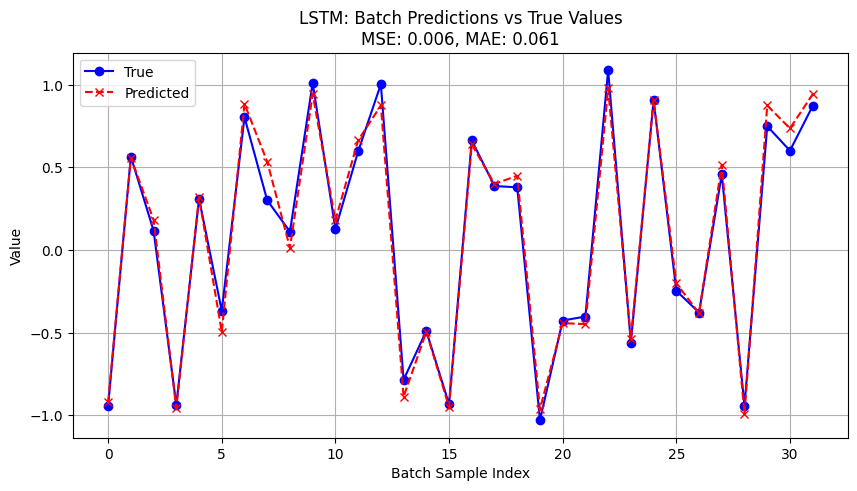

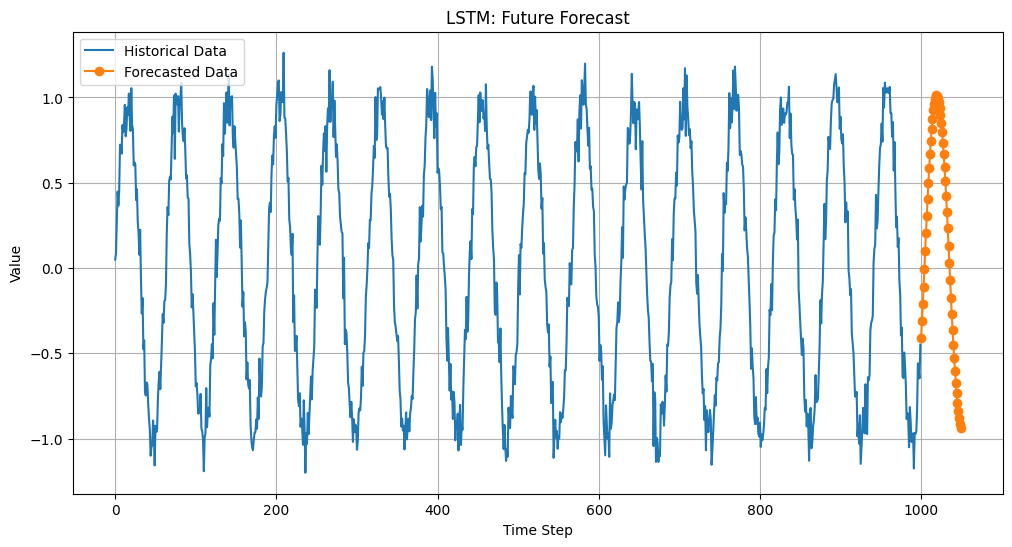

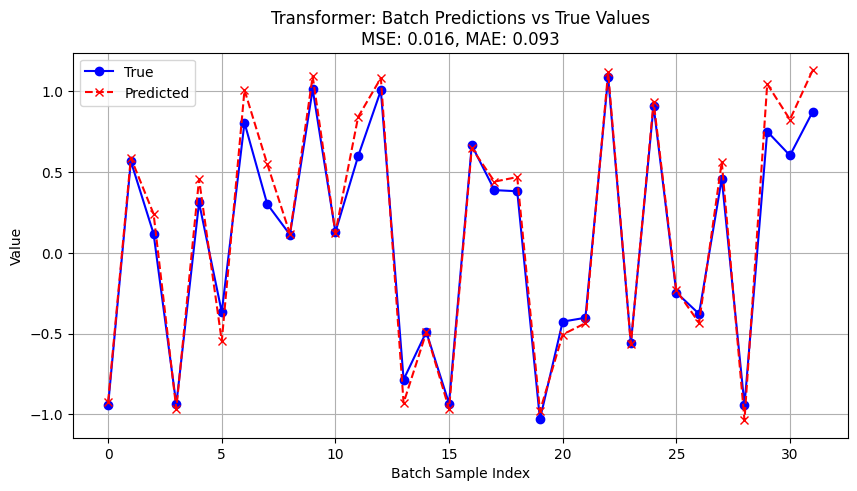

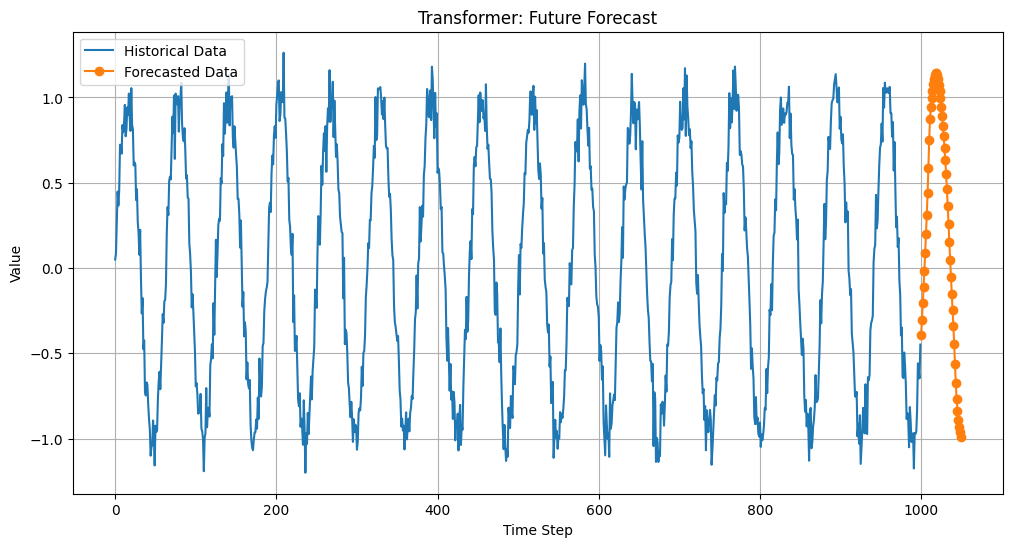

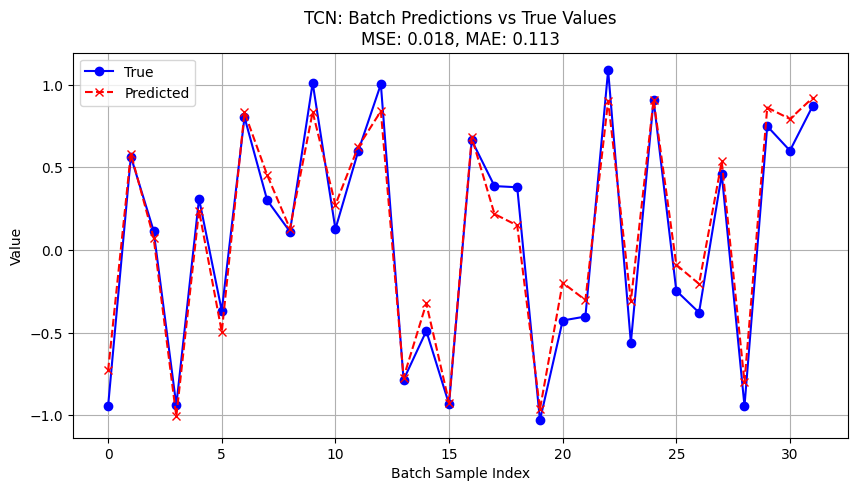

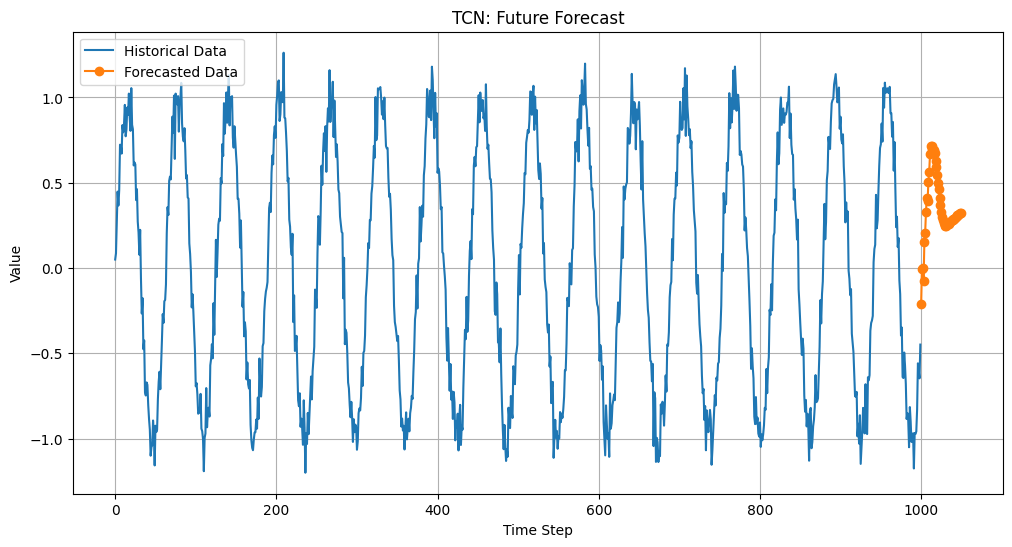

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# -----------------------------------------------------------
# Visualization for Batch Predictions with Error Metrics
# -----------------------------------------------------------
def plot_batch_predictions(model, dataloader, title="Model Predictions vs True Values"):
    model.eval()
    # Get a single batch from the validation loader
    batch = next(iter(dataloader))
    x, y = batch
    with torch.no_grad():
        preds = model(x).squeeze().cpu().numpy()
    y_true = y.squeeze().cpu().numpy()
    
    # Compute error metrics
    mse = np.mean((preds - y_true) ** 2)
    mae = np.mean(np.abs(preds - y_true))
    
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="True", marker="o", linestyle='-', color='blue')
    plt.plot(preds, label="Predicted", marker="x", linestyle='--', color='red')
    plt.xlabel("Batch Sample Index")
    plt.ylabel("Value")
    plt.title(f"{title}\nMSE: {mse:.3f}, MAE: {mae:.3f}")
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------------------------------------
# Visualization for Multi-Step Forecasting
# -----------------------------------------------------------
def plot_future_forecast(model, data, seq_length, forecast_steps=50, title="Future Forecast"):
    model.eval()
    # Start with the last sequence from the full dataset
    input_seq = torch.FloatTensor(data[-seq_length:]).unsqueeze(0).unsqueeze(-1)  # shape: [1, seq_length, 1]
    predictions = []
    
    with torch.no_grad():
        for _ in range(forecast_steps):
            pred = model(input_seq)  # shape: [1, 1]
            predictions.append(pred.item())
            # Update the sequence: remove the first value and append the new prediction.
            # Remove unsqueeze(0) to avoid an extra dimension.
            input_seq = torch.cat([input_seq[:, 1:, :], pred.unsqueeze(-1)], dim=1)
    
    # Plot historical data and the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(data)), data, label="Historical Data")
    plt.plot(np.arange(len(data), len(data) + forecast_steps), predictions, label="Forecasted Data", marker="o")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------------------------------------
# Visualize Predictions for Each Model
# -----------------------------------------------------------
# For LSTM Model
plot_batch_predictions(model_lstm, val_loader, title="LSTM: Batch Predictions vs True Values")
plot_future_forecast(model_lstm, data, seq_length, forecast_steps=50, title="LSTM: Future Forecast")

# For Transformer Model
plot_batch_predictions(model_transformer, val_loader, title="Transformer: Batch Predictions vs True Values")
plot_future_forecast(model_transformer, data, seq_length, forecast_steps=50, title="Transformer: Future Forecast")

# For TCN Model
plot_batch_predictions(model_tcn, val_loader, title="TCN: Batch Predictions vs True Values")
plot_future_forecast(model_tcn, data, seq_length, forecast_steps=50, title="TCN: Future Forecast")